# Feature Extraction

Flow aggregation by a time window

Generated features:
* NumSrcPorts
* NumDestAddr
* NumDestPorts
* NumFlows
* NumBytes
* NumPackets

## Imports

In [329]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import glob
import time
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import warnings

warnings.filterwarnings("ignore")

## Functions

In [266]:
def extract_features(input_df):
    # Take only the botnet part
    df_botnet = input_df[input_df['Label'].str.contains("flow=From-Botnet")]
    df_botnet.loc[:, "StartTime"] = pd.to_datetime(df_botnet.StartTime, format='%Y/%m/%d %H:%M:%S.%f')
    df_botnet.sort_values(by=['StartTime'], inplace=True)
    df_botnet.reset_index(drop=True, inplace=True)
#     df_botnet.head()
    
    
    # Determine the time windows
    time_windows = [0]
    for i in range(1, len(df_botnet)):
        # Find the optimal time window duration
        if (df_botnet["StartTime"][i] - df_botnet["StartTime"][time_windows[-1]]).seconds > 30:
            time_windows.append(i)

    time_windows.append(len(df_botnet)) # Added it for easier indexing             
    
    
    # Determined column keys
    column_keys = ["NumSrcPorts", "NumDestAddr", "NumDestPorts", "NumFlows", "NumBytes", "NumPackets"]
    gen_df = pd.DataFrame(None, columns=column_keys)

    # Generate the features for each time window
    for i in range(len(time_windows)-1):
        current_df = df_botnet.iloc[time_windows[i]:time_windows[i+1],:]

        group = current_df.groupby("SrcAddr")

        for address, addr_df in group:
            # TODO: Optionally source ip address can be added
#             print(address)

            num_src_ports = len(addr_df.Sport.unique())

            num_dest_addr = len(addr_df.DstAddr.unique())

            num_dest_ports = len(addr_df.Dport.unique())

            num_flows = len(addr_df)

            # TODO: SrcBytes or TotBytes?
            num_bytes = np.sum(addr_df.SrcBytes)

            num_packets = np.sum(addr_df.TotPkts)
            

            curr_gen_df = pd.DataFrame([[num_src_ports, num_dest_addr, num_dest_ports, num_flows, num_bytes, num_packets]], columns=column_keys)
            gen_df = gen_df.append(curr_gen_df, ignore_index=True)
            
    return gen_df


def extract_features_all(data_path):
    scenario_list = os.listdir(data_path)
    print(scenario_list)

    feat_list = []
    
    for scenario in scenario_list:
        scenario_path = os.path.join(data_path, scenario)
        
        if os.path.isdir(scenario_path):
            print(scenario)
            flow_file_path = glob.glob(os.path.join(scenario_path, "*.binetflow"))[0]
            
            # Extract features for the current scenario
            input_df = pd.read_csv(flow_file_path)
            scenario_features = extract_features(input_df)
            
            # Append scenario label
            scenario_features.loc[:, "Scenario"] = int(scenario)
            
            feat_list.append(scenario_features)
            
    return pd.concat(feat_list)

## Load and process data

In [267]:
DATA_PATH = os.path.join("..", "Project\ctu-13")

start_time = time.time()
gen_feat_df = extract_features_all(DATA_PATH)
print("--- %s seconds ---" % (time.time() - start_time))
gen_feat_df.head()

['1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
1


C:\Users\Burki\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Burki\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


10
11
12
13
2
3
4
5
6
7
8
9
--- 121.1137797832489 seconds ---


,NumSrcPorts,NumDestAddr,NumDestPorts,NumFlows,NumBytes,NumPackets,Scenario
0,2,2,2,3,780,11,1
1,10,7,6,18,15072,510,1
2,22,18,6,24,20881,659,1
3,13,13,4,13,2771,47,1
4,16,15,4,16,7261,183,1


# Machine Learning Models

## Generate test and train sets

In [280]:
# Generate test and train sets
X = gen_feat_df.iloc[:, range(0, 6)].values
y = gen_feat_df.iloc[:, 6].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Feature Counts
print("Feature Counts\n")
print("num\ttrain\ttest\ttotal")
print("-" * 30)
for i in range(1, 14):
    print("{0}\t{1}\t{2}\t{3}".format(i, np.count_nonzero(y_train==i), np.count_nonzero(y_test==i), np.count_nonzero(y==i)))
print("-" * 30)
print("total:\t{0}\t{1}\t{2}".format(len(y_train), len(y_test), len(y)))

Feature Counts

num	train	test	total
------------------------------
1	355	176	531
2	262	98	360
3	1188	489	1677
4	93	42	135
5	25	10	35
6	139	60	199
7	2	2	4
8	828	362	1190
9	1858	798	2656
10	345	132	477
11	10	4	14
12	81	44	125
13	1263	547	1810
------------------------------
total:	6449	2764	9213


### Scale data

In [283]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Evaluation Functions

In [286]:
def print_results():
    print("\nAccuracy:")
    print(metrics.accuracy_score(y_test, y_pred))
    
    print("\nClassification report:")
    print(metrics.classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

## Logistic Regression

In [287]:
log_regression = LogisticRegression()

# Train the classifier
log_regression.fit(X_train, y_train)

# Predict
y_pred = log_regression.predict(X_test)

print_results()


Accuracy:
0.6924746743849494

Classification report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       176
          2       0.00      0.00      0.00        98
          3       0.80      0.95      0.87       489
          4       0.00      0.00      0.00        42
          5       0.00      0.00      0.00        10
          6       0.00      0.00      0.00        60
          7       0.00      0.00      0.00         2
          8       0.77      0.72      0.75       362
          9       0.63      0.93      0.75       798
         10       0.98      0.37      0.54       132
         11       0.00      0.00      0.00         4
         12       0.00      0.00      0.00        44
         13       0.64      0.72      0.68       547

avg / total       0.60      0.69      0.63      2764


Confusion Matrix:
[[  0   0   1   0   0   0   0   0 167   0   0   0   8]
 [  0   0   2   0   0   0   0   0  94   0   0   0   2]
 [  0   0 466   0  

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## KNN
Tries for different k values and prints the metrics for the k value with the best accuracy

Results for k=5

Accuracy:
0.8798842257597684

Classification report:
             precision    recall  f1-score   support

          1       0.70      0.68      0.69       176
          2       0.52      0.58      0.55        98
          3       0.98      0.98      0.98       489
          4       0.46      0.31      0.37        42
          5       0.14      0.10      0.12        10
          6       0.70      0.65      0.67        60
          7       0.00      0.00      0.00         2
          8       0.95      0.95      0.95       362
          9       0.91      0.92      0.92       798
         10       0.83      0.95      0.88       132
         11       0.00      0.00      0.00         4
         12       0.79      0.68      0.73        44
         13       0.90      0.89      0.89       547

avg / total       0.88      0.88      0.88      2764


Confusion Matrix:
[[119  23   0   2   0   1   0   1  24   0   0   0   6]
 [ 25  57   0   1   0   3   0   0   6   0   0   0   6]
 [ 

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


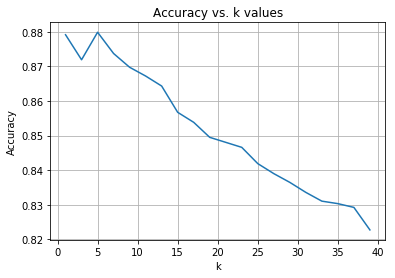

In [317]:
acc_vals = []
k_vals = []
pred_vals = []

for i in range(20):
    k = 2*i+1
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    acc_vals.append(metrics.accuracy_score(y_test, y_pred))
    k_vals.append(k)
    pred_vals.append(y_pred)

# print_results()
plt.plot(k_vals, acc_vals)
plt.title("Accuracy vs. k values")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot the results for best k value
i_max_acc = acc_vals.index(max(acc_vals))
print("Results for k={0}".format(2*i_max_acc+1))

y_pred = pred_vals[i_max_acc]
print_results()

## 10-fold KNN

In [325]:
knn = KNeighborsClassifier(n_neighbors=k)
scores = cross_val_score(knn, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.84 (+/- 0.02)


## 10-fold Logistic Regression

In [326]:
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.71 (+/- 0.02)


## SVM

In [323]:
svm_clf = svm.SVC(kernel='rbf', C=5)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print_results()


Accuracy:
0.8183791606367583

Classification report:
             precision    recall  f1-score   support

          1       0.60      0.72      0.65       176
          2       0.69      0.52      0.59        98
          3       0.93      0.95      0.94       489
          4       0.00      0.00      0.00        42
          5       0.00      0.00      0.00        10
          6       0.56      0.23      0.33        60
          7       0.00      0.00      0.00         2
          8       0.66      0.90      0.76       362
          9       0.93      0.89      0.91       798
         10       0.80      0.65      0.72       132
         11       0.00      0.00      0.00         4
         12       1.00      0.14      0.24        44
         13       0.82      0.88      0.85       547

avg / total       0.81      0.82      0.80      2764


Confusion Matrix:
[[126  13   0   0   0   2   0   5  25   0   0   0   5]
 [ 33  51   0   0   0   1   0   3   7   0   0   0   3]
 [  1   0 463   0  

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [313]:
rand_forest_clf = RandomForestClassifier(n_estimators=10, bootstrap=False)

rand_forest_clf.fit(X_train, y_train)

y_pred = rand_forest_clf.predict(X_test)

print_results()


Accuracy:
0.9052098408104197

Classification report:
             precision    recall  f1-score   support

          1       0.73      0.81      0.77       176
          2       0.74      0.58      0.65        98
          3       0.98      0.99      0.99       489
          4       0.48      0.36      0.41        42
          5       0.20      0.10      0.13        10
          6       0.73      0.82      0.77        60
          7       0.00      0.00      0.00         2
          8       0.96      0.97      0.96       362
          9       0.94      0.95      0.94       798
         10       0.91      0.89      0.90       132
         11       0.00      0.00      0.00         4
         12       0.84      0.73      0.78        44
         13       0.90      0.91      0.90       547

avg / total       0.90      0.91      0.90      2764


Confusion Matrix:
[[143  10   0   1   0   0   0   0  11   0   0   0  11]
 [ 27  57   0   0   0   1   0   0   3   0   0   0  10]
 [  2   0 483   0  

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [293]:
importances = np.round(rand_forest_clf.feature_importances_, 3)
features = list(gen_feat_df.columns[:-1])
pd.DataFrame(np.array([features, importances]).T, columns=['Features', 'Importance'])

,Features,Importance
0,NumSrcPorts,0.174
1,NumDestAddr,0.132
2,NumDestPorts,0.093
3,NumFlows,0.198
4,NumBytes,0.193
5,NumPackets,0.211


In [213]:
#https://stats.stackexchange.com/questions/130206/sklearn-tree-export-graphviz-values-do-not-add-up-to-samples

from sklearn.tree import export_graphviz

feature_names = gen_feat_df.columns[:-1]
class_names = [str(i) for i in rand_forest_clf.classes_]

export_graphviz(rand_forest_clf.estimators_[0],
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True)

os.system('dot -Tpng tree.dot -o tree.png')

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\tree\export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


0

## 10-fold Random Forest

In [316]:
rand_forest_clf = RandomForestClassifier(n_estimators=10)

scores = cross_val_score(rand_forest_clf, X_train, y_train, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Burki\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.92 (+/- 0.02)
